# Carbon Emission Prediction Model

In [2]:
from datetime import date
import time
import torch # pip install torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import os
from ipynb.fs.defs.train_benchmark import process_data; # pip install ipynb
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset load and preprocess

In [3]:
# Set dataset locations
selected_output_variable = "NO2"
data_file = "01_Data/02_Imagery/data_and_imagery_test.pkl"

In [4]:
X, y, res, num_channels, m = process_data(data_file, selected_output_variable) # from benchmark code
# reshape and convert datatype
X = torch.from_numpy(X.T).to(torch.float)
y = torch.from_numpy(y.T).to(torch.float)

# split dataset
percent_train = 0.80
num_train = int(percent_train * m)
num_test = m - num_train
print('num training samples: ', num_train)
print('num testing samples: ', num_test)

X_train, X_test = torch.utils.data.random_split(X, [num_train, num_test])
y_train, y_test = torch.utils.data.random_split(y, [num_train, num_test])

# convert from Subset to Tensor type
X_train, X_test = X_train.dataset[X_train.indices], X_test.dataset[X_test.indices]
y_train, y_test = y_train.dataset[y_train.indices], y_test.dataset[y_test.indices]

num training samples:  1543
num testing samples:  386


## Define model

In [5]:
class Net(nn.Module):
    """
    Define the neural network: 1 hidden layer with ReLU activation
    """
    def __init__(self, res, num_channels, m):
        """
        Define the network layers
        """
        super(Net,self).__init__()
        self.layer1 = nn.Linear(res*res*num_channels, m) # computes W^T X + b
        
    def forward(self, x):
        """
        Define forward pass
        """
        x = torch.nn.functional.relu(self.layer1(x)) # ReLU activation
        return x

## Train model

In [6]:
def plot_learning(train_loss, test_loss, model_tag):
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['Train loss', 'Test loss'])
    path = os.path.join('03_Trained_Models', 'NN', 'images', 'model_%s_%s.png' %(date.today(), model_tag.replace('.', '-')))
    plt.savefig(path)
    plt.show()
    plt.clf()

In [7]:
def train(x_train, y_train, x_test, y_test, num_epochs, save=False, model_tag=''):
    """
    Train model on training data. If save=True, trained model is saved in ./03_Trained_Models/NN/model_date_<model_tag>.pt
    Input:
        x data and labels
    Output:
        trained model
    """
    print('Training...')
    t0 = time.time()
    train_losses = []
    test_losses = []
    optimizer.zero_grad() # clear gradients
    for epoch in range(num_epochs):
        output = net(x_train)
        loss = criterion(output, y_train)
        if (epoch%10 == 0): # save every 10th loss
            # Train losses
            train_losses.append(loss)
            print('\tloss at epoch %i = %f' %(epoch, loss))
            # Track test losses
            test_output = net(x_test)
            test_loss = criterion(test_output, y_test).item()
            test_losses.append(test_loss)
            print('\ttest loss at epoch %i = %f\n' %(epoch, test_loss))
        loss.backward()
        optimizer.step()

    # Plot training and test loss
    plot_learning(train_losses, test_losses, model_tag)
    
    # save trained model and training details
    if (save):
        train_date = date.today()
        folder_path = os.path.join('03_Trained_Models', 'NN', 'model_%s_%s' %(train_date, model_tag))
        if (not os.path.exists(folder_path)):
            os.mkdir(folder_path)
        
        # save trained model
        path = os.path.join(folder_path, 'model_%s_%s.pt' %(train_date, model_tag))
        torch.save(net.state_dict(), path)
        
        # save training details
        path = os.path.join(folder_path, 'model_%s_%s_training.txt' %(train_date, model_tag))
        with open(path, 'w') as f:
            f.write("Size of x_train: %s" %(str(x_train.shape)))
            f.write("\nSize of y_train: %s\n" %(str(y_train.shape)))
            f.write("\n Train loss")
            for i, loss in enumerate(train_losses):
                f.write("\nLoss at epoch %i: %f" %(i*10, loss))
            f.write("\n Test loss")
            for i, loss in enumerate(test_losses):
                f.write("\nTest Loss at epoch %i: %f" %(i*10, loss))
            f.write("\n\nTotal train time: %fs" %(time.time() - t0))
        
    return net

## Define hyperparameters

In [8]:
num_epochs = 100 # number iterations

# Varying learning rates
alphas = [0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1]

# Varying number of layers
#Ls = [1, 5, 10, 20, 50, 75]

# Varying optimizers
optimizers = ['SGD', 'Adam']

# Number of iterations 
num_epochs_ = [100, 250, 500, 1000] 

## Main

Training with learning rate: 0.0001
Training...


C:\Users\ninap\miniconda3\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1543, 1])) that is different to the input size (torch.Size([1543, 1929])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ninap\miniconda3\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([386, 1])) that is different to the input size (torch.Size([386, 1929])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	loss at epoch 0 = 259.848755
	test loss at epoch 0 = 139.797958

	loss at epoch 10 = 259.761108
	test loss at epoch 10 = 139.710388

	loss at epoch 20 = 259.508881
	test loss at epoch 20 = 139.458588

	loss at epoch 30 = 259.087921
	test loss at epoch 30 = 139.038483

	loss at epoch 40 = 258.498688
	test loss at epoch 40 = 138.450500

	loss at epoch 50 = 257.743866
	test loss at epoch 50 = 137.697433

	loss at epoch 60 = 256.828400
	test loss at epoch 60 = 136.784485

	loss at epoch 70 = 255.759903
	test loss at epoch 70 = 135.719391

	loss at epoch 80 = 254.547531
	test loss at epoch 80 = 134.511383

	loss at epoch 90 = 253.201370
	test loss at epoch 90 = 133.170761



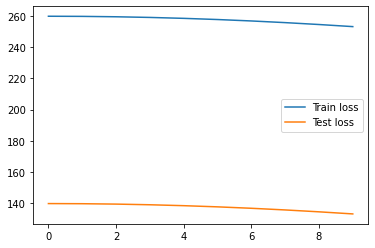

Training with learning rate: 0.0005
Training...
	loss at epoch 0 = 251.732941
	test loss at epoch 0 = 131.709290

	loss at epoch 10 = 251.326599
	test loss at epoch 10 = 131.304993

	loss at epoch 20 = 250.190567
	test loss at epoch 20 = 130.175125

	loss at epoch 30 = 248.371277
	test loss at epoch 30 = 128.366882

	loss at epoch 40 = 245.944794
	test loss at epoch 40 = 125.957993

	loss at epoch 50 = 243.018341
	test loss at epoch 50 = 123.057411

	loss at epoch 60 = 239.723892
	test loss at epoch 60 = 119.799385

	loss at epoch 70 = 236.211273
	test loss at epoch 70 = 116.336197

	loss at epoch 80 = 232.643967
	test loss at epoch 80 = 112.833740

	loss at epoch 90 = 229.184891
	test loss at epoch 90 = 109.457214



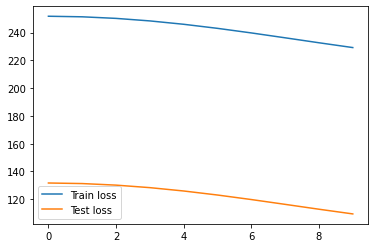

Training with learning rate: 0.001
Training...
	loss at epoch 0 = 225.991089
	test loss at epoch 0 = 106.365723

	loss at epoch 10 = 225.770477
	test loss at epoch 10 = 106.152260

	loss at epoch 20 = 225.163132
	test loss at epoch 20 = 105.565178

	loss at epoch 30 = 224.214691
	test loss at epoch 30 = 104.650772

	loss at epoch 40 = 223.000122
	test loss at epoch 40 = 103.484840

	loss at epoch 50 = 221.619965
	test loss at epoch 50 = 102.168900

	loss at epoch 60 = 220.189209
	test loss at epoch 60 = 100.818687

	loss at epoch 70 = 218.829330
	test loss at epoch 70 = 99.556351

	loss at epoch 80 = 217.663300
	test loss at epoch 80 = 98.504883

	loss at epoch 90 = 216.798080
	test loss at epoch 90 = 97.770393



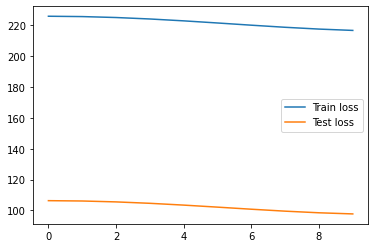

Training with learning rate: 0.01
Training...
	loss at epoch 0 = 216.307861
	test loss at epoch 0 = 97.425529

	loss at epoch 10 = 216.045441
	test loss at epoch 10 = 97.168526

	loss at epoch 20 = 215.428467
	test loss at epoch 20 = 96.569977

	loss at epoch 30 = 214.888718
	test loss at epoch 30 = 96.067368

	loss at epoch 40 = 214.791031
	test loss at epoch 40 = 96.025787

	loss at epoch 50 = 215.092560
	test loss at epoch 50 = 96.391258

	loss at epoch 60 = 215.379730
	test loss at epoch 60 = 96.731201

	loss at epoch 70 = 215.315506
	test loss at epoch 70 = 96.692261

	loss at epoch 80 = 214.910080
	test loss at epoch 80 = 96.280144

	loss at epoch 90 = 214.439514
	test loss at epoch 90 = 95.779495



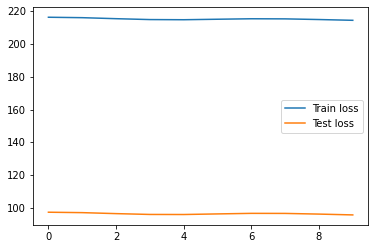

Training with learning rate: 0.05
Training...
	loss at epoch 0 = 214.270264
	test loss at epoch 0 = 95.571823

	loss at epoch 10 = 213.305008
	test loss at epoch 10 = 94.570259

	loss at epoch 20 = 213.488556
	test loss at epoch 20 = 94.739029

	loss at epoch 30 = 214.162750
	test loss at epoch 30 = 95.429474

	loss at epoch 40 = 213.261673
	test loss at epoch 40 = 94.526253

	loss at epoch 50 = 213.668701
	test loss at epoch 50 = 94.964226

	loss at epoch 60 = 214.064774
	test loss at epoch 60 = 95.376167

	loss at epoch 70 = 213.150345
	test loss at epoch 70 = 94.432663

	loss at epoch 80 = 213.703018
	test loss at epoch 80 = 94.997704

	loss at epoch 90 = 213.874008
	test loss at epoch 90 = 95.191498



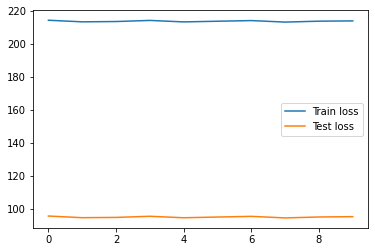

Training with learning rate: 0.1
Training...
	loss at epoch 0 = 213.053284
	test loss at epoch 0 = 94.381500

	loss at epoch 10 = 212.923050
	test loss at epoch 10 = 94.241257

	loss at epoch 20 = 213.043869
	test loss at epoch 20 = 94.361694

	loss at epoch 30 = 212.903061
	test loss at epoch 30 = 94.232231

	loss at epoch 40 = 213.014893
	test loss at epoch 40 = 94.363991

	loss at epoch 50 = 212.864655
	test loss at epoch 50 = 94.214684

	loss at epoch 60 = 212.966629
	test loss at epoch 60 = 94.325851

	loss at epoch 70 = 212.808319
	test loss at epoch 70 = 94.188309

	loss at epoch 80 = 212.899765
	test loss at epoch 80 = 94.310326

	loss at epoch 90 = 212.734741
	test loss at epoch 90 = 94.157242



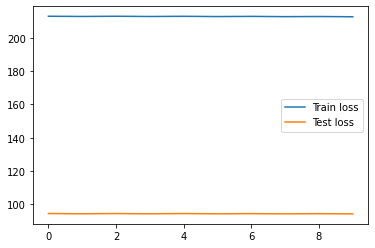

Training optimizer: SGD
Training...
	loss at epoch 0 = 212.815002
	test loss at epoch 0 = 94.256195

	loss at epoch 10 = 212.708954
	test loss at epoch 10 = 94.152763

	loss at epoch 20 = 212.733337
	test loss at epoch 20 = 94.187599

	loss at epoch 30 = 212.800247
	test loss at epoch 30 = 94.262161

	loss at epoch 40 = 212.680435
	test loss at epoch 40 = 94.138733

	loss at epoch 50 = 212.727463
	test loss at epoch 50 = 94.185211

	loss at epoch 60 = 212.761047
	test loss at epoch 60 = 94.225182

	loss at epoch 70 = 212.636475
	test loss at epoch 70 = 94.112175

	loss at epoch 80 = 212.701614
	test loss at epoch 80 = 94.195892

	loss at epoch 90 = 212.698441
	test loss at epoch 90 = 94.204208



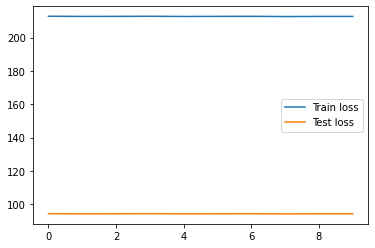

Training optimizer: Adam
Training...
	loss at epoch 0 = 212.578003
	test loss at epoch 0 = 94.086563

	loss at epoch 10 = 260.864075
	test loss at epoch 10 = 140.811279

	loss at epoch 20 = 260.864075
	test loss at epoch 20 = 140.811279

	loss at epoch 30 = 260.864075
	test loss at epoch 30 = 140.811279

	loss at epoch 40 = 260.864075
	test loss at epoch 40 = 140.811279

	loss at epoch 50 = 260.864075
	test loss at epoch 50 = 140.811279

	loss at epoch 60 = 260.864075
	test loss at epoch 60 = 140.811279

	loss at epoch 70 = 260.864075
	test loss at epoch 70 = 140.811279

	loss at epoch 80 = 260.864075
	test loss at epoch 80 = 140.811279

	loss at epoch 90 = 260.864075
	test loss at epoch 90 = 140.811279



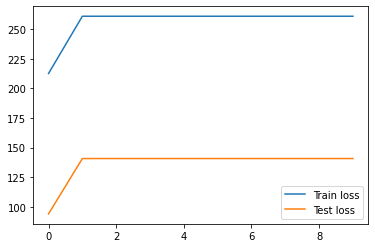

Training number of epochs: 100
Training...
	loss at epoch 0 = 260.864075
	test loss at epoch 0 = 140.811279

	loss at epoch 10 = 260.864075
	test loss at epoch 10 = 140.811279

	loss at epoch 20 = 260.864075
	test loss at epoch 20 = 140.811279

	loss at epoch 30 = 260.864075
	test loss at epoch 30 = 140.811279

	loss at epoch 40 = 260.864075
	test loss at epoch 40 = 140.811279

	loss at epoch 50 = 260.864075
	test loss at epoch 50 = 140.811279

	loss at epoch 60 = 260.864075
	test loss at epoch 60 = 140.811279

	loss at epoch 70 = 260.864075
	test loss at epoch 70 = 140.811279

	loss at epoch 80 = 260.864075
	test loss at epoch 80 = 140.811279

	loss at epoch 90 = 260.864075
	test loss at epoch 90 = 140.811279



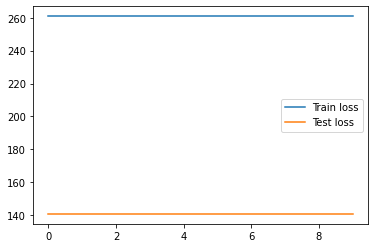

Training number of epochs: 250
Training...
	loss at epoch 0 = 260.864075
	test loss at epoch 0 = 140.811279

	loss at epoch 10 = 260.864075
	test loss at epoch 10 = 140.811279

	loss at epoch 20 = 260.864075
	test loss at epoch 20 = 140.811279

	loss at epoch 30 = 260.864075
	test loss at epoch 30 = 140.811279

	loss at epoch 40 = 260.864075
	test loss at epoch 40 = 140.811279

	loss at epoch 50 = 260.864075
	test loss at epoch 50 = 140.811279

	loss at epoch 60 = 260.864075
	test loss at epoch 60 = 140.811279

	loss at epoch 70 = 260.864075
	test loss at epoch 70 = 140.811279

	loss at epoch 80 = 260.864075
	test loss at epoch 80 = 140.811279

	loss at epoch 90 = 260.864075
	test loss at epoch 90 = 140.811279

	loss at epoch 100 = 260.864075
	test loss at epoch 100 = 140.811279

	loss at epoch 110 = 260.864075
	test loss at epoch 110 = 140.811279

	loss at epoch 120 = 260.864075
	test loss at epoch 120 = 140.811279

	loss at epoch 130 = 260.864075
	test loss at epoch 130 = 140.811279


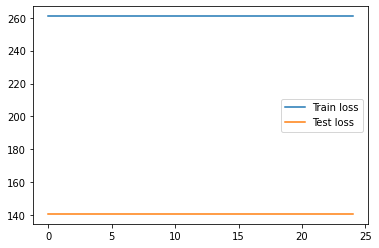

Training number of epochs: 500
Training...
	loss at epoch 0 = 260.864075
	test loss at epoch 0 = 140.811279

	loss at epoch 10 = 260.864075
	test loss at epoch 10 = 140.811279

	loss at epoch 20 = 260.864075
	test loss at epoch 20 = 140.811279

	loss at epoch 30 = 260.864075
	test loss at epoch 30 = 140.811279

	loss at epoch 40 = 260.864075
	test loss at epoch 40 = 140.811279

	loss at epoch 50 = 260.864075
	test loss at epoch 50 = 140.811279

	loss at epoch 60 = 260.864075
	test loss at epoch 60 = 140.811279

	loss at epoch 70 = 260.864075
	test loss at epoch 70 = 140.811279

	loss at epoch 80 = 260.864075
	test loss at epoch 80 = 140.811279

	loss at epoch 90 = 260.864075
	test loss at epoch 90 = 140.811279

	loss at epoch 100 = 260.864075
	test loss at epoch 100 = 140.811279

	loss at epoch 110 = 260.864075
	test loss at epoch 110 = 140.811279

	loss at epoch 120 = 260.864075
	test loss at epoch 120 = 140.811279

	loss at epoch 130 = 260.864075
	test loss at epoch 130 = 140.811279


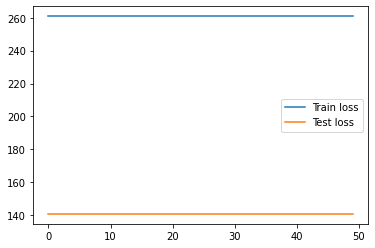

Training number of epochs: 1000
Training...
	loss at epoch 0 = 260.864075
	test loss at epoch 0 = 140.811279

	loss at epoch 10 = 260.864075
	test loss at epoch 10 = 140.811279

	loss at epoch 20 = 260.864075
	test loss at epoch 20 = 140.811279

	loss at epoch 30 = 260.864075
	test loss at epoch 30 = 140.811279

	loss at epoch 40 = 260.864075
	test loss at epoch 40 = 140.811279

	loss at epoch 50 = 260.864075
	test loss at epoch 50 = 140.811279

	loss at epoch 60 = 260.864075
	test loss at epoch 60 = 140.811279

	loss at epoch 70 = 260.864075
	test loss at epoch 70 = 140.811279

	loss at epoch 80 = 260.864075
	test loss at epoch 80 = 140.811279

	loss at epoch 90 = 260.864075
	test loss at epoch 90 = 140.811279

	loss at epoch 100 = 260.864075
	test loss at epoch 100 = 140.811279

	loss at epoch 110 = 260.864075
	test loss at epoch 110 = 140.811279

	loss at epoch 120 = 260.864075
	test loss at epoch 120 = 140.811279

	loss at epoch 130 = 260.864075
	test loss at epoch 130 = 140.811279

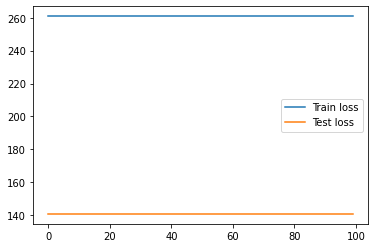

<Figure size 432x288 with 0 Axes>

In [9]:
# Initialize network
net = Net(res, num_channels, m)
L = len(list(net.parameters())) # number of layers
# print(net)

# Initialize loss function and optimizer
if 'AQI' in selected_output_variable:
    criterion = nn.CrossEntropyLoss() # classification
else:
    criterion = nn.MSELoss() # regression

# Test learning rates
for alpha in alphas:
    print("Training with learning rate: {}".format(alpha))
    optimizer = optim.SGD(net.parameters(), lr=alpha)

    # train model and save to ./03_Trained_Models/NN/model_date_<model_tag>.pt
    model_tag = '1_hidden_relu__alpha_{}'.format(alpha)
    train(X_train, y_train, X_test, y_test, num_epochs, True, model_tag)
    
# Test optimizers
for optimizer_name in optimizers:
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.05)
    else: 
        optimizer = optim.Adam(net.parameters(), lr=0.05)
    
    print("Training optimizer: {}".format(optimizer_name))
    model_tag = '1_hidden_relu__optimizer_{}'.format(optimizer_name)
    train(X_train, y_train, X_test, y_test, num_epochs, True, model_tag)
    
# Test iterations
for num_epochs in num_epochs_:
    print("Training number of epochs: {}".format(num_epochs))
    optimizer = optim.SGD(net.parameters(), lr=0.05)

    # train model and save to ./03_Trained_Models/NN/model_date_<model_tag>.pt
    model_tag = '1_hidden_relu__epochs_{}'.format(num_epochs)
    train(X_train, y_train, X_test, y_test, num_epochs, True, model_tag)
    
# Test trained model
#print('Testing')
#output = net(X_test)
#loss = criterion(output, y_test).item()
#print('\tTest loss = ', loss)